# Modeling Inviscid Flows with Point Sources

In this discussion, we'll take a look at how we can use point sources to model inviscid flows past obstacles.
The code in this document is written in [Julia](https://www.julialang.org), but it should be straightforward to try this in any language of your choice.

## Some Setup Code

The code here is really only used to draw the pathlines.
It might be useful to [skip](#The-Rankine-Half-Body) this section, and come back to it later if you are curious.

In [1]:
# Install libraries if necessary
for pkg in ["PotentialFlow", "Plots"]
    try
        Pkg.installed(pkg)
    catch
        Pkg.add(pkg)
    end
end

using PotentialFlow 

# Set default plotting options
using Plots
default(markerstrokealpha = 0, legend = false, ratio = 1,
        dpi = 100, size = (400, 300), grid = false)
clibrary(:colorbrewer);

Once we have computed the velocity field around the obstable, we will draw a couple pathlines by simulating the trajectory of passive tracer particles.
To do this, we need to provide a couple functions:

In [2]:
"""
Given the source distribution and freestream, returns a 
function that computes the velocity of the tracer particles
"""
function make_state_equation(sources, U∞)
    # Here, `x` is a vector containing the current positions
    # of the tracer particles, and `ẋ` is vector that that
    # their velocities will be written into.  The `t` variable
    # stands for the current time.
    function (ẋ, x, t)
        fill!(ẋ, U∞)
        induce_velocity!(ẋ, x, sources, t)
    end
end

"""
Given the current location and velocity of the tracers,
compute their location after a small time step
"""
function update_x!(x₊, x₋, ẋ, Δt)
    @. x₊ = x₋ + ẋ*Δt
end

update_x!

We will then use a 4th-order Runge-Kutta scheme to simulate the trajectories of the tracers.

In [3]:
function trace_pathlines(sources, U∞, start_pos, T)
    states = [copy(start_pos) for i in 1:length(T)+1]
    ẋs = [allocate_velocity(start_pos) for i in 1:4]
    
    compute_ẋ! = make_state_equation(sources, U∞)

    for (i, t) in enumerate(T)
        rk4!(states[i+1], states[i], t, step(T), compute_ẋ!, update_x!, ẋs)
    end
    
    transpose(hcat(states...))
end

trace_pathlines (generic function with 1 method)

In [4]:
"""
Compute the component of `w` in the `n̂` direction
"""
component(n̂, w) = real(conj(n̂)*w)

component

## The Rankine Half Body

$$
\newcommand{\compose}[2]{#1 \circ #2}
\newcommand{\ddp}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\dpt}[1]{\ddp{#1}{t}}
\newcommand{\dd}[2]{\frac{\mathrm{d}#1}{\mathrm{d}#2}}
\newcommand{\ddt}[1]{\dd{#1}{t}}
\renewcommand{\vec}[1]{\boldsymbol{#1}}
\newcommand{\cross}{\times}
\newcommand{\abs}[1]{\left|#1\right|}
\renewcommand{\d}{\,\mathrm{d}}
\renewcommand{\div}{\nabla \cdot}
\renewcommand{\curl}{\nabla \cross}
\newcommand{\grad}{\nabla}
\newcommand{\lap}{\nabla^2}
\newcommand{\uvec}[1]{\vec{#1}}
\newcommand{\utangent}{\uvec{\tau}}
\newcommand{\unormal}{\uvec{n}}
\newcommand{\im}{\mathrm{i}}
\newcommand{\eu}{\mathrm{e}}
\newcommand{\pint}{\int}
\newcommand{\inv}[1]{{#1}^{-1}}
\newcommand{\conj}[1]{#1^\star}
\newcommand{\Res}[2]{\mathrm{Res}\left(#1,#2\right)}
\newcommand{\real}[1]{\mathrm{Re}\left\{#1\right\}}
\newcommand{\imag}[1]{\mathrm{Im}\left\{#1\right\}}
\newcommand{\normal}[1]{#1^\perp}
\newcommand{\tangent}[1]{#1^\parallel}
\newcommand{\residue}[2]{\mathrm{Res}\left(#1, #2\right)}
$$
Let's start with a simple freestream in the $x$-direction with velocity $U_\infty$, and a point source at the origin.
What should the strength of this point source be in order to make $(-1, 0)$ a stagnation point?

Recall that the velocity field induced by a point source at $\vec{x}_s$ with strength $S$ is given by:

\begin{equation}
    \vec{u}_S(\vec{x})
  = \frac{S}{2\pi}
    \frac{\vec{x} - \vec{x}_s}
         {\abs{\vec{x} - \vec{x}_s}}.
\end{equation}

We want the velocity induced by the freestream and the point vortex to be zero at $(-1, 0)$, i.e.

\begin{equation}
\begin{bmatrix}U_\infty \\ 0\end{bmatrix} + \vec{u}_s\left(\begin{bmatrix}-1 \\ 0\end{bmatrix}\right) = 0
\end{equation}
Since $\vec{x}_s = \begin{bmatrix} 0 & 0 \end{bmatrix}^T$, we have
\begin{equation}
U_\infty - \frac{S}{2\pi} = 0,
\end{equation}

which give us $S = 2\pi U_\infty$.
Let's see what that looks like.

We first set the freestream velocity and create a single point source:

In [5]:
U∞ = 1.0
source = Source.Point(0, 2π*U∞)

Source.Point(0.0 + 0.0im, 6.283185307179586)

We will seed 30 tracer particles along the $x=-3$ line, spanning $y \in [-3, 3]$, and track their trajectory over 20 seconds:

In [6]:
tracer_start = -3.0 .+ linspace(-3,3,30)*im;
T = 0:1e-2:20

freestream = trace_pathlines((), U∞, tracer_start, T)
freestream_with_source = trace_pathlines(source, U∞, tracer_start, T);

which looks like this:


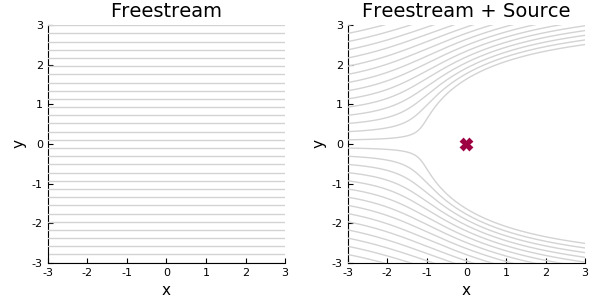

In [7]:
plt = plot(layout = 2, size = (600, 300))
plot!(plt[1], freestream, color = colorant"lightgray", xlabel = "x", ylabel = "y",
      xlim = (-3, 3), ylim = (-3, 3), title = "Freestream")
plot!(plt[2], freestream_with_source, color = colorant"lightgray", xlabel = "x", ylabel = "y",
      xlim = (-3, 3), ylim = (-3, 3), title = "Freestream + Source")
plot!(plt[2], [source], markersize = 10)

What would have happened if the point source was placed off the $y$-axis?
We will then have
\begin{align*}
U_\infty - \frac{S}{2\pi} & = 0 \\
\frac{S}{2\pi} \frac{y}{1 + y^2} & = 0.
\end{align*}
This means that we cannot zero out the horizontal velocity without imparting a vertical velocity.
So instead of a stagnation point, we have a point that stops flow in only one direction.
That's not really useful on its own, but in the next section we will see how we can use whole bunch of point sources to stop flow from going through a whole bunch places.

## A whole bunch of point sources

Suppose we want to model a solid surface in an inviscid fluid.
The only role of that surface is to prevent fluid from going through it.
We can accomplish the same thing by replacing the surface with a **source sheet**.
We haven't covered source sheets yet, but you can think of it as a source where the strength is distributed along a curve instead of being concentrated at a single point.
Since we will be discretizing the sheet into small segments, and represent those segments as point sources anyways, you can temporarily forget what I said about the sheets and just think of it as a lot of point sources.

Let's start by considering flow past a equilateral triangle.
We will discretize this triangle into small segments, each with length $\Delta s$.
This will look something like:


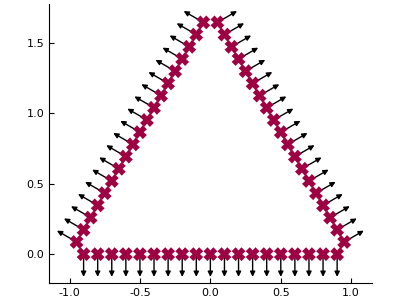

In [8]:
Δs = 0.1
s = -(1 - Δs):Δs:(1 - Δs)

bottom = Source.Point.(s, 1.0);
right  = Source.Point.((s + 1).*exp(im*2π/3) + 1, 1.0);
left   = Source.Point.((s .+ 1)*exp(-im*2π/3) + im*√3, 1.0);

sources = vcat(bottom, right, left)
targets = Elements.position.(sources);

n̂ = vcat(
    fill(-1.0im, length(bottom)),
    fill(exp(im*π/6), length(right)),
    fill(exp(im*5π/6), length(left)));

Δs = fill(Δs, length(n̂));

plot(sources, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)
plot!(sources, markersize = 10)

where the red cross marks correspond to the center of each segment (which we represent with a single point source), and the arrows correspond to the normal vectors along the surface.

So the velocity at any point in the fluid is equal to the freestream plus the velocity induced by each of the $N$ point sources:

\begin{equation}
\vec{u}(\vec{x}) = \vec{U}_\infty + \sum_{n = 1}^N \vec{u}_n(\vec{x})
\end{equation}

If we want enforce the no-flow-through condition at the point sources, then we must have

\begin{equation}
\sum_{n = 1}^N \uvec{n}_i \cdot \vec{u}_n(\vec{x}_i) = - \uvec{n}_i \cdot \vec{U}_\infty \qquad \text{for } i = 1, 2, \cdots, N.
\end{equation}

As long as the we are not evaluating the velocity that a segment induces on itself, we will treat the segment as a point source:

\begin{equation}
    \vec{u}_n(\vec{x})
  = S_n \cdot \underbrace{\frac{1}{2\pi}
    \frac{\vec{x} - \vec{x}_n}
         {\abs{\vec{x} - \vec{x}_n}}}_{\uvec{u}_n(\vec{x})} \qquad \text{when } \vec{x} \neq \vec{x}_n
\end{equation}

But how **would** we evaluate $\vec{u}_n(\vec{x}_n)$?  We probably won't go over it in class, so you'll just have to believe ([or not](#Or-Not)) that it somehow is:

\begin{equation}
\vec{u}_n(\vec{x}_n) = \frac{S_n}{\Delta s}
\end{equation}

<a id="back"></a>

So the no-flow-through condition above can be written in matrix form:

\begin{equation}
\underbrace{
\begin{bmatrix}
1/\Delta s & \uvec{n}_1 \cdot \frac{1}{2\pi}\frac{\vec{x}_1 - \vec{x}_2}{\abs{\vec{x}_1 - \vec{x}_2}^2}
& \cdots & \uvec{n}_1 \cdot \frac{1}{2\pi}\frac{\vec{x}_1 - \vec{x}_N}{\abs{\vec{x}_1 - \vec{x}_N}^2}
\\
\uvec{n}_2 \cdot \frac{1}{2\pi}\frac{\vec{x}_2 - \vec{x}_1}{\abs{\vec{x}_2 - \vec{x}_1}^2} & 1/\Delta s
& & \vdots
\\
\vdots & & \ddots & \vdots \\
\uvec{n}_N \cdot \frac{1}{2\pi}\frac{\vec{x}_N - \vec{x}_1}{\abs{\vec{x}_N - \vec{x}_1}^2} &
\cdots & \cdots &
1 / \Delta s
\end{bmatrix}}_{A}
\begin{bmatrix}
S_1 \\
S_2 \\
\vdots \\
\vdots \\
S_n
\end{bmatrix}
=
\underbrace{
-
\begin{bmatrix}
\uvec{n}_1 \cdot \vec{U}_\infty \\
\uvec{n}_2 \cdot \vec{U}_\infty \\
\vdots \\
\vdots \\
\uvec{n}_N \cdot \vec{U}_\infty \\
\end{bmatrix}}_{b},
\end{equation}

which we can solve to find the strengths of the point sources.
In code, this will look something like:

In [9]:
b = -component.(n̂, U∞);

A = [component(n, induce_velocity(target, source, 0)) for (n, target) in zip(n̂, targets), source in sources]
A .+= 0.5*diagm(1./Δs);

S = A \ b;


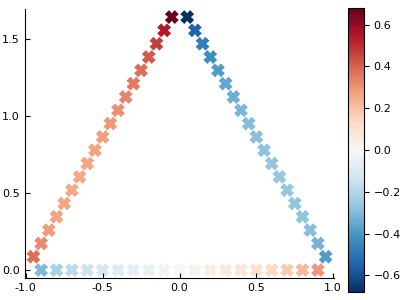

In [10]:
sources = Source.Point.(targets, S)

plot(sources, color = :RdBu_r, colorbar = :right, markersize = 10)

In the figure above, red x's correspond to sources while blue x's correspond to sinks.
Now, we will seed a line of tracer particles along $x = -3$ and advect them in time to trace out pathlines:


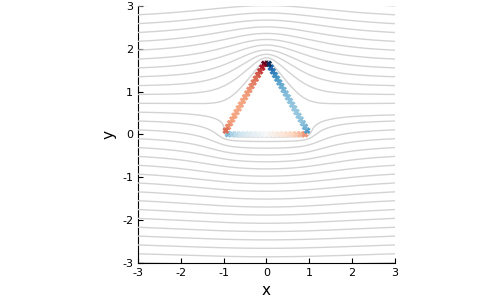

In [11]:
tracers = trace_pathlines(sources, U∞, tracer_start, T)

plot(tracers, color = colorant"lightgray", xlabel = "x", ylabel = "y",
     xlim = (-3, 3), ylim = (-3, 3), size = (500, 300))
plot!(sources, markersize = 5, color = :RdBu_r)

> **Food for thought**
>
> - Did the sources *have* to be on the surface of the body?
> - Can we achieve the same result with $N$ point sources placed *inside* the body?
> - Why not place the sources outside the body?

Before moving on, we'll wrap all of this into a function so we don't have to keep repeating ourselves.

In [12]:
function simulate_flow(sources, Δs, n̂, U∞; tracer_start = -3.0 .+ linspace(-3,3,30)*im, T = 0:1e-2:20)
    b = -component.(n̂, U∞);

    A = [component(n, induce_velocity(target, source, 0)) for (n, target) in zip(n̂, targets), source in sources]
    A .+= 0.5*diagm(1./Δs);

    S = A \ b;
    
    sources = Source.Point.(targets, S)
    
    tracers = trace_pathlines(sources, U∞, tracer_start, T)

    plt = plot(tracers, color = colorant"lightgray", xlabel = "x", ylabel = "y",
               xlim = (-3, 3), ylim = (-3, 3), size = (500, 300))
    plot!(plt, sources, markersize = 2, color = :RdBu_r)
    
    plt, sources, tracers
end

simulate_flow (generic function with 1 method)

### Flow Past a Cylinder

As before, we first construct the surface of the body with point sources:


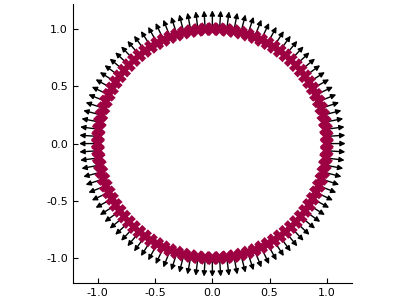

In [13]:
θ = linspace(0, 2π, 101)[1:end-1]
Δs = fill(step(θ), length(θ))
sources = Source.Point.(exp.(im.*θ), 1.0);
targets = Elements.position.(sources)
n̂ = Elements.position.(sources);

plot(sources, ratio = 1)
quiver!(real.(targets), imag.(targets), quiver = 0.15.*(real.(n̂), imag.(n̂)), color = :black)
plot!(sources, markersize = 10)

Now with a freestream from left to right, we have;


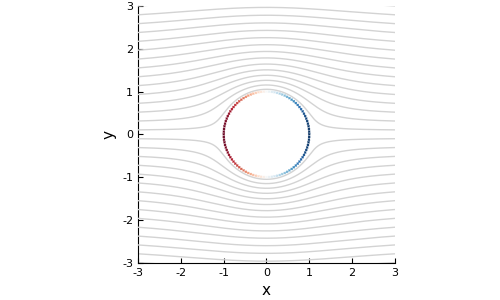

In [14]:
plt, actual_sources, tracers = simulate_flow(sources, Δs, n̂, 1.0)
plt

Now with a downward freestream, this becomes:


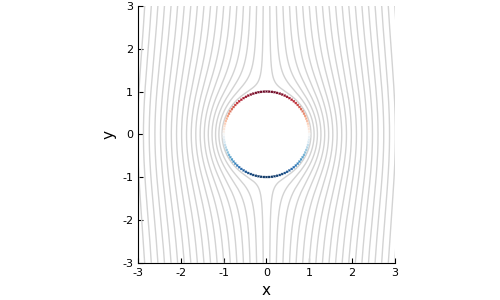

In [15]:
plt, actual_sources, tracers = simulate_flow(sources, Δs, n̂, -im, tracer_start = linspace(-3,3,40) .+ 3im)
plt

### Flow Past a Happy Face


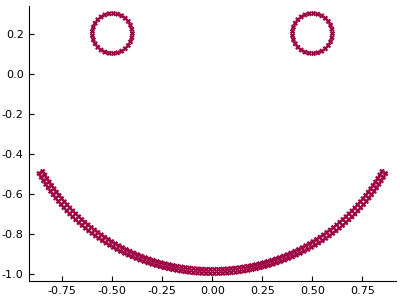

In [16]:
θ = linspace(π/6, 5π/6, 100)
Δs = step(θ)
targets = exp.(-im*θ)
n̂ = targets;
targets = vcat(targets, flipdim((1 - Δs)*targets, 1))
n̂ = vcat(n̂, -flipdim(n̂, 1))
n̂[1] *= im
n̂[50] *= -im

Δs = abs.(gradient(targets))

θᵢ = linspace(0, 2π, 30)[1:end-1]
left_eye = 0.1exp.(im*θᵢ) - 0.5 + 0.2im
right_eye = 0.1exp.(im*θᵢ) + 0.5 + 0.2im;

append!(targets, left_eye)
append!(targets, right_eye)
append!(Δs, fill(0.5π/length(θᵢ), 2length(θᵢ)))
append!(n̂, exp.(im*θᵢ))
append!(n̂, exp.(im*θᵢ))

sources = Source.Point.(targets, 1.0);
plot(sources, ratio = 1)

With $U_\infty$ going downward:


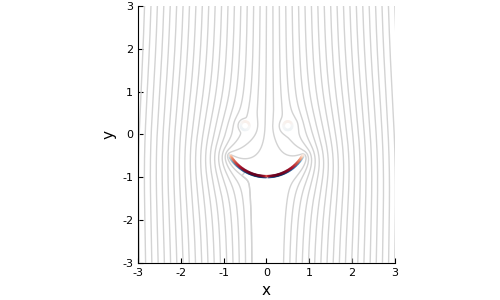

In [17]:
plt, actual_sources, tracers = simulate_flow(sources, Δs, n̂, -1.0im, tracer_start = linspace(-3,3,41) .+ 3im)
plt

With $U_\infty$ going from left to right:


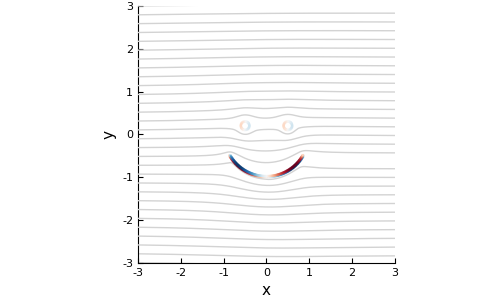

In [18]:
plt, actual_sources, tracers = simulate_flow(sources, Δs, n̂, 1.0)
plt

## Appendix

### Or Not

We'll have to discuss source sheets for a little bit here to find out the velocity that the sheet induces on itself.
To keep it simple, we will use a straight sheet segment with length $\Delta s$ centered around the origin.
The equation describing this sheet segment is given by:

\begin{equation}
    \vec{u}_s(\vec{x})
  = \frac{1}{2\pi}
    \int_{-\Delta s/2}^{\Delta s/2}
        \sigma(l) \frac{\vec{x} - \vec{x}_s(l)}
                  {\abs{\vec{x} - \vec{x}_s(l)}}
        \d{l},
\end{equation}

where $\sigma$ is the local strength of the sheet.
This is not all that different from the point sources, except when you approach the sheet.

We first assume that $\Delta s$ is small enough that $\sigma$ is essentially constant in the interval.
Then, if we parametrize the target point as

\begin{equation}
\vec{x} = r\cos\theta\,\uvec{i} + r\sin\theta\,\uvec{j},
\end{equation}

we obtain

\begin{align*}
    \vec{u}_s(\vec{x})
& = \frac{\sigma(0)}{2\pi}
    \left[ \uvec{i}
    \int_{-\Delta s/2}^{\Delta s/2}
               \frac{(r\cos\theta - l)}
                    {\abs{\vec{x} - \vec{x}_s(l)}}
               \d{l}
         + \uvec{j}
           \int_{-\Delta s/2}^{\Delta s/2}
               \frac{r\cos\theta}
                    {\abs{\vec{x} - \vec{x}_s(l)}}
               \d{l}
   \right]
\\
& =-\frac{\sigma(0)}{2\pi}
    \left( \frac{\uvec{i}}{2}
           \log\left[ (r\cos\theta - l)^2
                    + (r\sin\theta)^2
              \right]_{-\Delta s/2}^{\Delta s/2}
         + \left. \uvec{j}
                  \tan^{-1 }\left(\frac{r\cos\theta - l}
                                       {r\sin\theta}
                           \right)
          \right|_{-\Delta s/2}^{\Delta s/2}
   \right)
\end{align*}

As $\vec{x}$ approaches the origin, $r$ goes to zero

\begin{equation}
    \lim_{r \rightarrow 0}
    \vec{u}_s(\vec{x})
  = \mathrm{sign}(\theta)\frac{\sigma(0)}{2}.
\end{equation}

Since we are using point sources to model a segment of a source sheet, its strength $S$ is distributed along the segment, i.e.

\begin{equation}
S = \int_{-\Delta s/2}^{\Delta s/2} \sigma(l) \d{l}.
\end{equation}

For a short sheet segment, we assume that $\sigma$ is essentially constant along the segment, so we have $\sigma \approx \frac{S}{\Delta s}$, which finally gives us

\begin{equation}
\lim_{r \rightarrow 0} \uvec{u}_s(\vec{x}) = \frac{S}{2\Delta s}
\end{equation}

You can go [back](#back) now.